In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr

from glob import glob
import seaborn as sns

import numpy as np
import pandas as pd

import warnings


C:\Users\duncan\miniconda3\envs\climatebench\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\duncan\miniconda3\envs\climatebench\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Users\duncan\miniconda3\envs\climatebench\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
SECONDS_IN_YEAR = 60*60*24*365 #s
convert = lambda x: x * SECONDS_IN_YEAR * 1e-12 # kg -> Gt

AREA_of_EARTH = 510.1 * 1e6 #million km²

data_path = "F:\\Local Data\\ClimateBench\\"

# Only future scenarios for now
inputs = glob(data_path + "inputs_s*.nc")

def get_rmse(truth, pred):
    return np.sqrt(((truth-pred)**2))

def global_mean(ds):
    weights = np.cos(np.deg2rad(ds.latitude))
    return ds.weighted(weights).mean(['latitude', 'longitude'])

def global_sum(ds):
    weights = np.cos(np.deg2rad(ds.latitude))
    return ds.weighted(weights).sum(['latitude', 'longitude'])


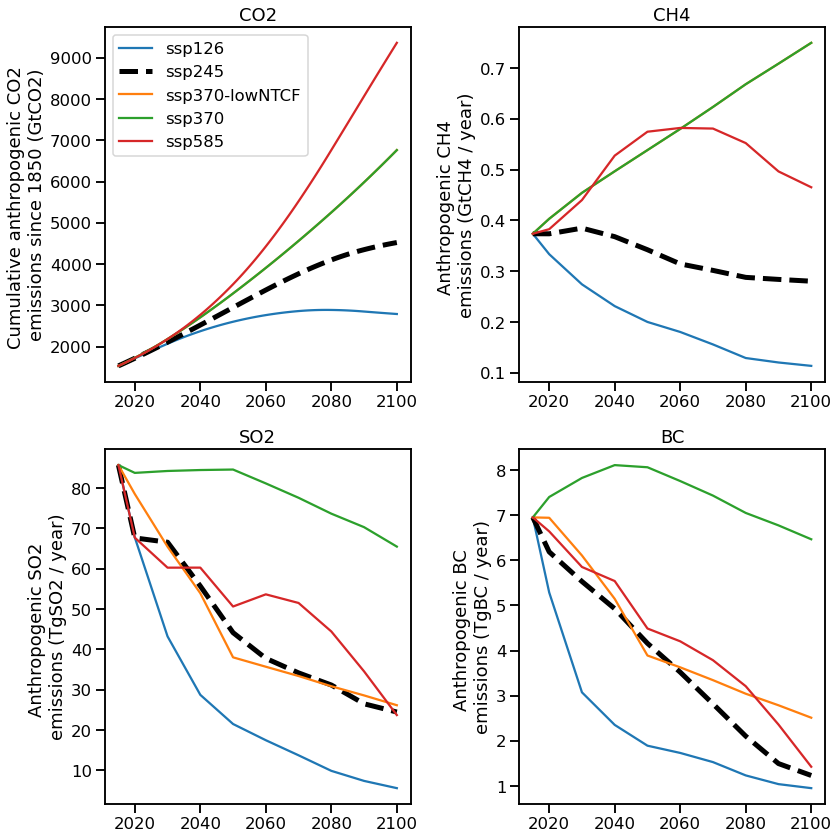

In [3]:
with sns.plotting_context("talk"):

    fig, axes = plt.subplots(2, 2, figsize=(12,12))

    for input in inputs:
        label=input.split('_')[1][:-3]
        X = xr.open_dataset(input)
        x = range(2015, 2101)
        
        kwargs = {}
        if label == "ssp245":
            kwargs['color'] = 'black'
            kwargs['ls'] = '--'
            kwargs['lw'] = '5'
        axes[0, 0].plot(x, X['CO2'], label=label, **kwargs)
        axes[0, 0].set_ylabel("Cumulative anthropogenic CO2 \nemissions since 1850 (GtCO2)")
        axes[0, 1].plot(x, X['CH4'], label=label, **kwargs)
        axes[0, 1].set_ylabel("Anthropogenic CH4 \nemissions (GtCH4 / year)")
        # FIXME: Not sure where this factor of 1000 comes from...! Maybe the CEDS data is really g/m-2/s?
        axes[1, 0].plot(x, convert(global_sum(X['SO2']*AREA_of_EARTH*1000*100)), label=label, **kwargs)
        axes[1, 0].set_ylabel("Anthropogenic SO2 \nemissions (TgSO2 / year)")
        axes[1, 1].plot(x, convert(global_sum(X['BC']*AREA_of_EARTH*1000*100)), label=label, **kwargs)
        axes[1, 1].set_ylabel("Anthropogenic BC \nemissions (TgBC / year)")

    axes[0, 0].set_title('CO2')
    axes[0, 1].set_title('CH4')
    axes[1, 0].set_title('SO2')
    axes[1, 1].set_title('BC')
    axes[0, 0].legend()
    plt.tight_layout()

In [21]:
all_inputs = glob(data_path + "inputs_*.nc")
global_means = {}

def global_total(da):
    if 'latitude' in da.coords:
        if da.name in ['CO2', 'CH4', 'tas']:
            return global_mean(da)
        else:
            return convert(global_sum(da*AREA_of_EARTH*1000*100))
    else:
        return da

for inp in glob(data_path + "inputs_*.nc"):
    label=inp.split('_')[1][:-3]
    X = xr.open_dataset(inp)
    Y = xr.open_dataset(data_path + f"outputs_{label}.nc")
#     print(X.coords)
#     print(label)
    if label == "hist-aer":
        X = X.rename_vars({"CO4": "CO2"})
    if 'lat' in X.coords:
        X = X.rename({'lat': 'latitude', 'lon': 'longitude'})
    if 'lat' in Y.coords:
        Y = Y.rename({'lat': 'latitude', 'lon': 'longitude'})

    if label == "abrupt-4xCO2":
        X = X.sel(time=slice(None, None, 5))
    X['tas'] = Y['tas'].mean('member')
    
    global_means[label] = X.map(global_total).to_pandas()

# print(global_means)


In [22]:
df = pd.concat(global_means, names=['scenario', 'time']).reset_index()

In [13]:
idealised = 'Idealised'
scenario = 'Scenario'
historical = 'Historical'

name_map = {'1pctCO2': idealised, 'abrupt-4xCO2': idealised, 'hist-aer': idealised, 'hist-GHG': idealised, 
            'historical': historical, 
            'ssp126': scenario, 'ssp245': scenario, 'ssp370-lowNTCF': idealised, 'ssp370': scenario, 'ssp585': scenario}
df['Type'] = df.reset_index().apply(lambda x: name_map[x['scenario']], axis=1)

In [16]:
plot_df = df.rename(columns={"CO2": "Cumulative CO2 (GtCO2)",
                             "SO2": "SO2 (TgSO2 / year)",
                             "BC": "BC (TgBC / year)",
                             "CH4": "CH4 (GtCH4 / year)" }).drop(columns=['scenario', 'time'])

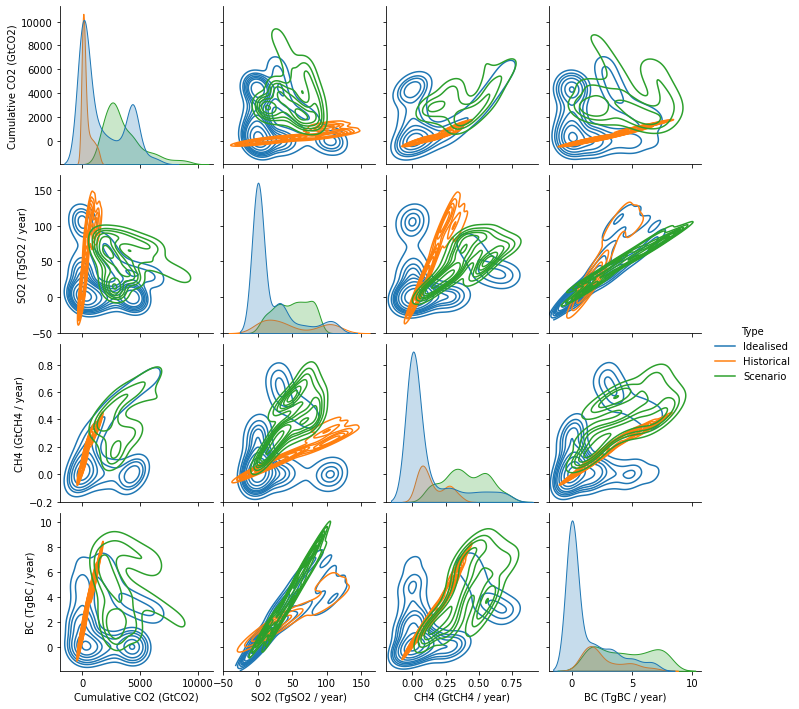

In [19]:
sns.pairplot(plot_df, hue="Type", kind='kde')
# Includes every 5th year from the 4xCo2 experiment since it's roughly 5 times longer than the others

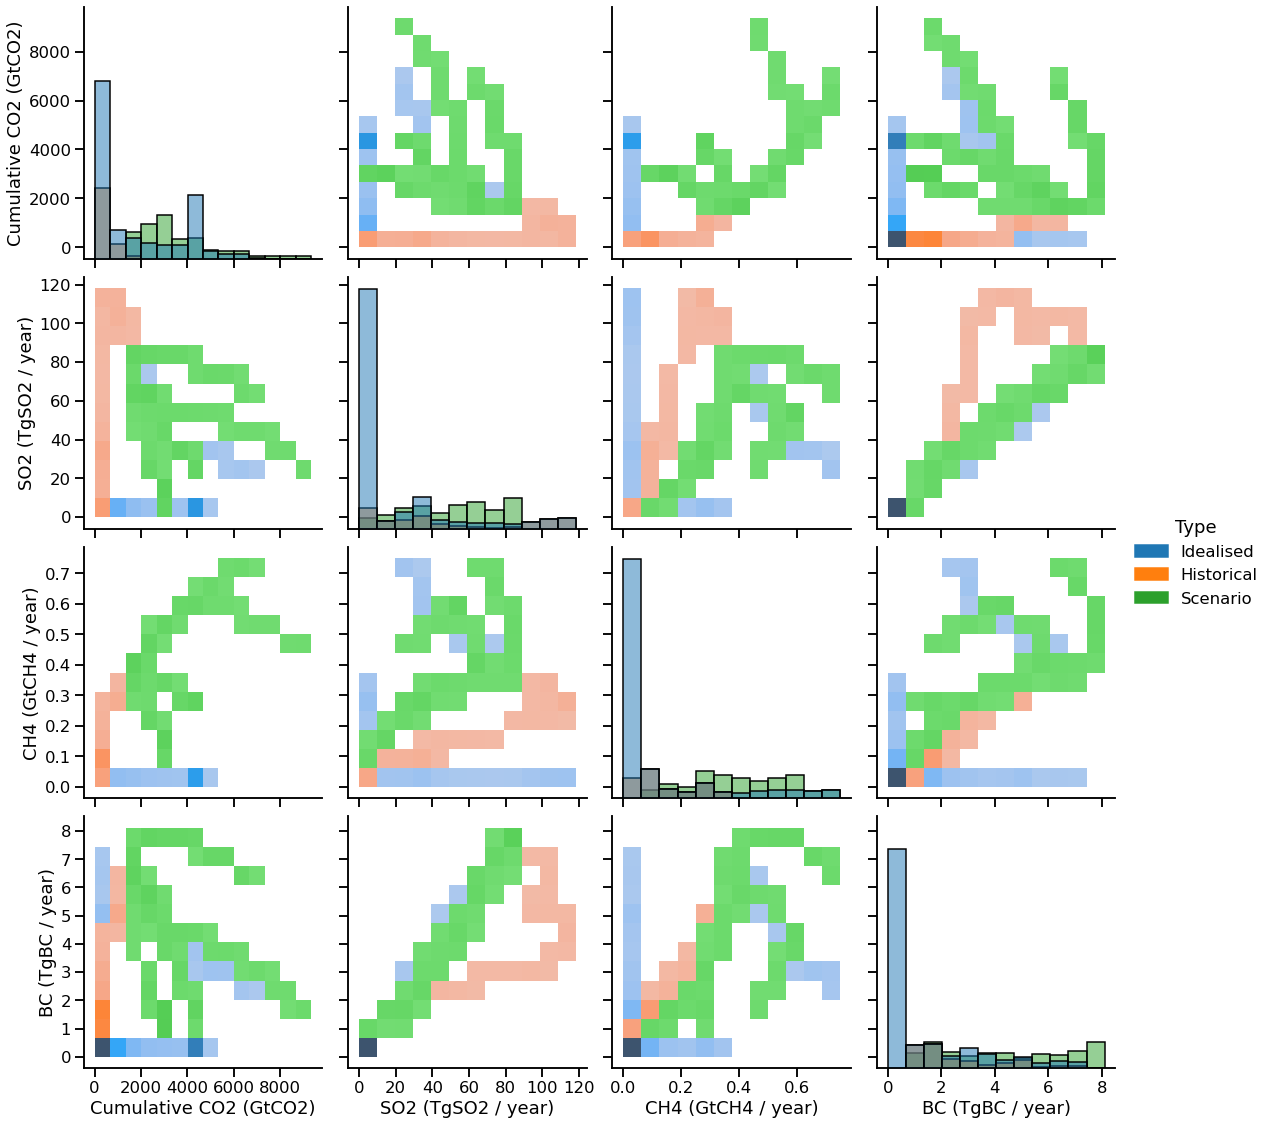

In [25]:
with sns.plotting_context("talk"):

#     fig = plt.figure(figsize=(12,12))

    sns.pairplot(plot_df, hue="Type", kind='hist', height=4)

In [63]:
# Get one combined historical + ssp585 timeseries for now
X = xr.open_mfdataset([data_path + 'inputs_historical.nc', data_path + 'inputs_ssp245.nc']).compute()

Y = xr.open_dataset(data_path + 'outputs_ssp245.nc')

# Convert the precip values to mm/day
Y["pr"] *= 86400
Y["pr90"] *= 86400

In [86]:
# Leave the projection as PlateCarree for dev then Mollweide for final plots (it's slow!)
proj = ccrs.Mollweide() 
# proj = ccrs.PlateCarree()

# Alternative approaches....:
# Sort the coordinates so that contourf works properly (pcolormesh takes forever in this projection)
# X.coords['longitude'] = (X.coords['longitude'] + 180) % 360 - 180
# X = X.sortby(X.longitude)
# Try adding a cyclic point, but losses the xarray goodness..
# from cartopy.util import add_cyclic_point 

In [66]:
# with sns.plotting_context("talk"):

#     fig = np.log(X["SO2"].sel(time=[1850, 1970, 2020, 2100])).plot.pcolormesh(col='time',col_wrap=2, vmin=-27, vmax=-20,  transform=ccrs.PlateCarree(),
#                                                                               subplot_kws=dict(projection=proj), figsize=(18, 8),
#                                                                               cbar_kwargs=dict(label='Log anthropogenic SO2 emissions (log kg / m2 / s)'))


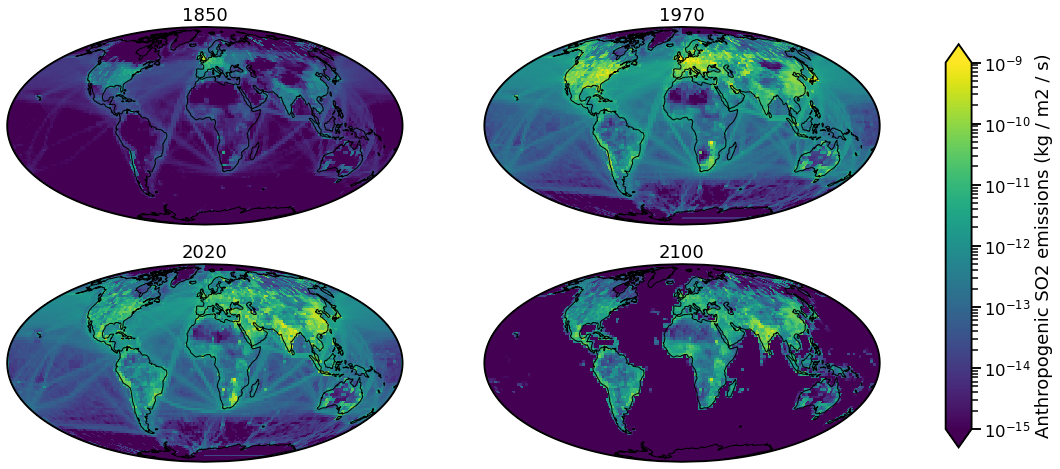

In [88]:
import matplotlib
with sns.plotting_context("talk"):

    norm = matplotlib.colors.LogNorm(1e-17, 1e-10, clip=True)
    norm = matplotlib.colors.LogNorm(1e-15, 1e-9, clip=True)
    fig = plt.figure(figsize=(18, 8))
    plt.subplot(221, projection=proj)
    X["SO2"].sel(time=1850).plot(transform=ccrs.PlateCarree(), add_colorbar=False, norm=norm)
    plt.gca().coastlines()
    plt.gca().set_title('1850')

    plt.subplot(222, projection=proj)
    X["SO2"].sel(time=1970).plot(transform=ccrs.PlateCarree(), add_colorbar=False, norm=norm)
    plt.gca().coastlines()
    plt.gca().set_title('1970')

    plt.subplot(223, projection=proj)
    X["SO2"].sel(time=2020).plot(transform=ccrs.PlateCarree(), add_colorbar=False, norm=norm)
    plt.gca().coastlines()
    plt.gca().set_title('2020')

    plt.subplot(224, projection=proj)
    m=X["SO2"].sel(time=2100).plot(transform=ccrs.PlateCarree(), add_colorbar=False, norm=norm)
    plt.gca().coastlines()
    plt.gca().set_title('2100')

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(m, cax=cbar_ax, extend='both')
    cbar.set_label('Anthropogenic SO2 emissions (kg / m2 / s)')

C:\Users\duncan\miniconda3\envs\climatebench\lib\site-packages\xarray\core\computation.py:733: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
C:\Users\duncan\miniconda3\envs\climatebench\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\duncan\miniconda3\envs\climatebench\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\duncan\miniconda3\envs\climatebench\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed 

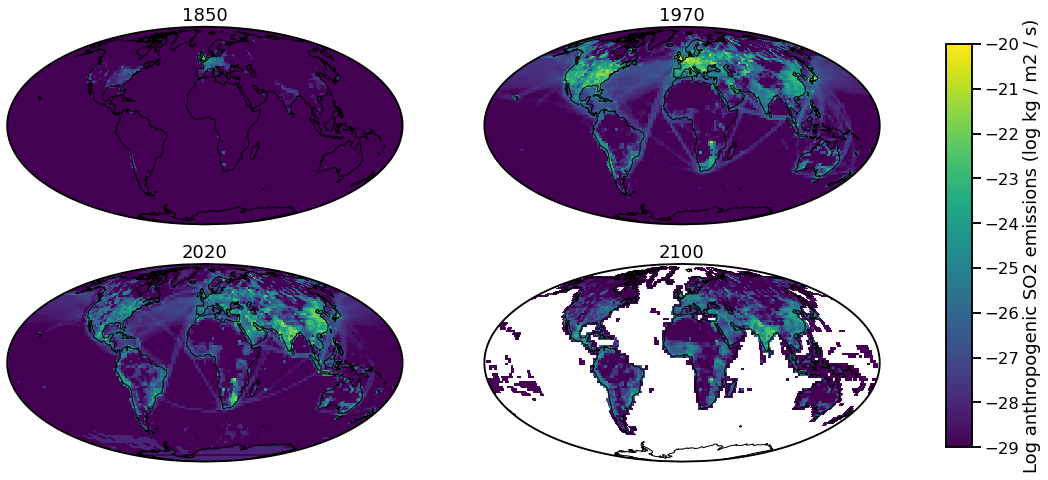

In [7]:
with sns.plotting_context("talk"):

    fig = plt.figure(figsize=(18, 8))
    plt.subplot(221, projection=proj)
    np.log(X["SO2"].sel(time=1850)).plot(vmin=-29, vmax=-20, transform=ccrs.PlateCarree(), add_colorbar=False)
    plt.gca().coastlines()
    plt.gca().set_title('1850')

    plt.subplot(222, projection=proj)
    np.log(X["SO2"].sel(time=1970)).plot(vmin=-29, vmax=-20, transform=ccrs.PlateCarree(), add_colorbar=False)
    plt.gca().coastlines()
    plt.gca().set_title('1970')

    plt.subplot(223, projection=proj)
    np.log(X["SO2"].sel(time=2020)).plot(vmin=-29, vmax=-20, transform=ccrs.PlateCarree(), add_colorbar=False)
    plt.gca().coastlines()
    plt.gca().set_title('2020')

    plt.subplot(224, projection=proj)
    m=np.log(X["SO2"].sel(time=2100)).plot(vmin=-29, vmax=-20, transform=ccrs.PlateCarree(), add_colorbar=False)
    plt.gca().coastlines()
    plt.gca().set_title('2100')

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(m, cax=cbar_ax)
    cbar.set_label('Log anthropogenic SO2 emissions (log kg / m2 / s)')

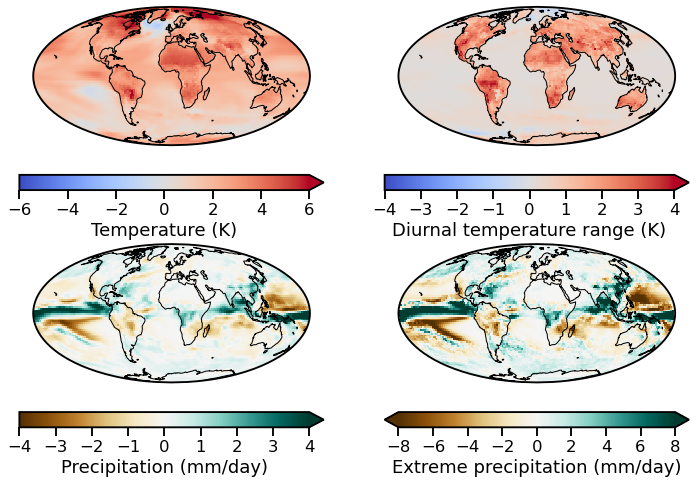

In [8]:
from matplotlib import colors
divnorm=colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=6)

with sns.plotting_context("talk"):

    fig = plt.figure(figsize=(12, 8))
    plt.subplot(221, projection=proj)
    Y["tas"].sel(time=2100, member=1).plot(cmap="coolwarm", vmax=6, transform=ccrs.PlateCarree(), add_labels=False,
                                  cbar_kwargs={"label":"Temperature (K)", "orientation":'horizontal'})
    plt.gca().coastlines()

    plt.subplot(222, projection=proj)
    Y["diurnal_temperature_range"].sel(time=2100, member=1).plot(cmap="coolwarm", vmax=4, transform=ccrs.PlateCarree(), add_labels=False,
                                                      cbar_kwargs={"label":"Diurnal temperature range (K)", "orientation":'horizontal'})
    plt.gca().coastlines()

    plt.subplot(223, projection=proj)
    #  Convert precip to mm/day
    (Y["pr"].sel(time=2100, member=1)).plot(cmap="BrBG", transform=ccrs.PlateCarree(), vmin=-4, vmax=4, add_labels=False,
                                 cbar_kwargs={"label":"Precipitation (mm/day)", "orientation":'horizontal'})
    plt.gca().coastlines()

    plt.subplot(224, projection=proj)
    (Y["pr90"].sel(time=2100, member=1)).plot(cmap="BrBG", transform=ccrs.PlateCarree(), vmin=-8, vmax=8, add_labels=False,
                                   cbar_kwargs={"label":"Extreme precipitation (mm/day)", "orientation":'horizontal'})
    plt.gca().coastlines()



In [41]:
variables = ['tas', 'diurnal_temperature_range', 'pr', 'pr90']
# rf_predictions = xr.open_dataset(data_path + 'outputs_ssp245_predict_RF.nc')
rf_predictions = xr.open_dataset(data_path + 'outputs_ssp245_prediction_ESEm.nc')
nn_predictions = xr.merge([{v: xr.open_dataarray(data_path + "outputs_ssp245_predict_{}.nc".format(v))} for v in variables])
gp_predictions = xr.merge([{v: xr.open_dataarray(data_path + "outputs_ssp245_predict_gp_{}.nc".format(v))} for v in variables])

In [42]:
# Convert the precip values to mm/day
nn_predictions["pr"] *= 86400
nn_predictions["pr90"] *= 86400

In [51]:
models = [rf_predictions, nn_predictions, gp_predictions, Y]
model_labels = ['Random Forest', "Neural Network", 'Gaussian Process', 'NorESM2']
labels = ["Temperature (K)", "Diurnal temperature range (K)", "Precipitation (mm/day)", "Extreme precipitation (mm/day)"]
kwargs = [dict(cmap="coolwarm", vmax=6), dict(cmap="coolwarm", vmin=-4, vmax=4), dict(cmap="BrBG", vmin=-4, vmax=4), dict(cmap="BrBG", vmin=-8, vmax=8)]

[[<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>]
 [<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>]
 [<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>]
 [<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>]]


C:\Users\duncan\miniconda3\envs\climatebench\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\duncan\miniconda3\envs\climatebench\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\duncan\miniconda3\envs\climatebench\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\duncan\miniconda3\envs\clima

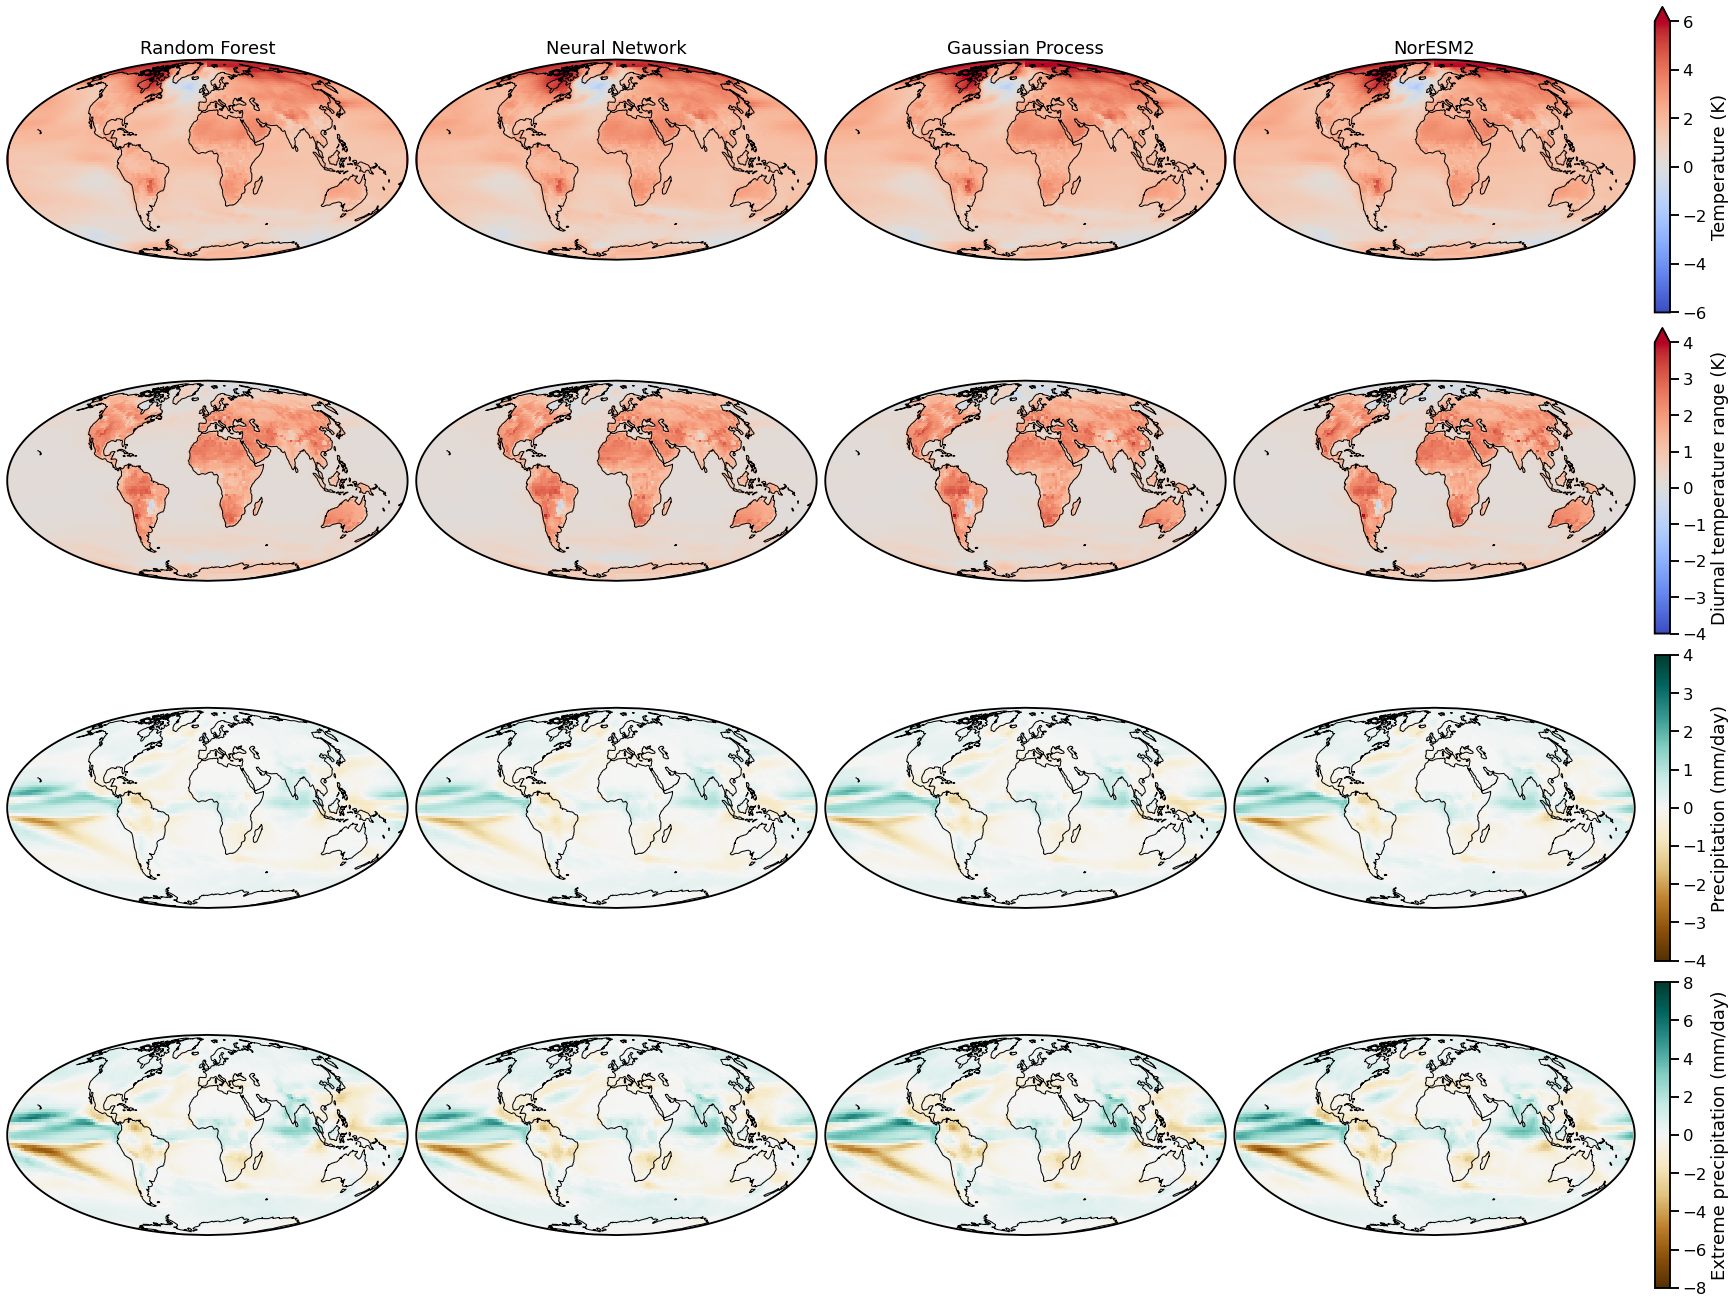

In [12]:
with sns.plotting_context("talk"):

#     fig = plt.figure()
    fig, axes = plt.subplots(4, 4, subplot_kw=dict(projection=proj), figsize=(24, 18), constrained_layout=True)
    print(axes)
    for model_axes, var, label, kws in zip(axes, variables, labels, kwargs):
        for ax, model, model_label in zip(model_axes, models, model_labels):
            if label == 'Temperature (K)':
                ax.set_title(model_label)
            if model_label == 'NorESM2':
                model[var].sel(time=slice(2050, 2100)).mean(['time', 'member']).plot(ax=ax, add_labels=False, transform=ccrs.PlateCarree(), cbar_kwargs={"label":label, "orientation":'vertical'}, **kws)
            else: 
                model[var].sel(time=slice(2050, 2100)).mean('time').plot(ax=ax, add_labels=False, transform=ccrs.PlateCarree(), add_colorbar=False, **kws)
            ax.coastlines()
                

[[<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>]
 [<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>]
 [<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>]
 [<GeoAxesSubplot:> <GeoAxesSubplot:> <GeoAxesSubplot:>]]


C:\Users\duncan\miniconda3\envs\climatebench\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\duncan\miniconda3\envs\climatebench\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\duncan\miniconda3\envs\climatebench\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\duncan\miniconda3\envs\clima

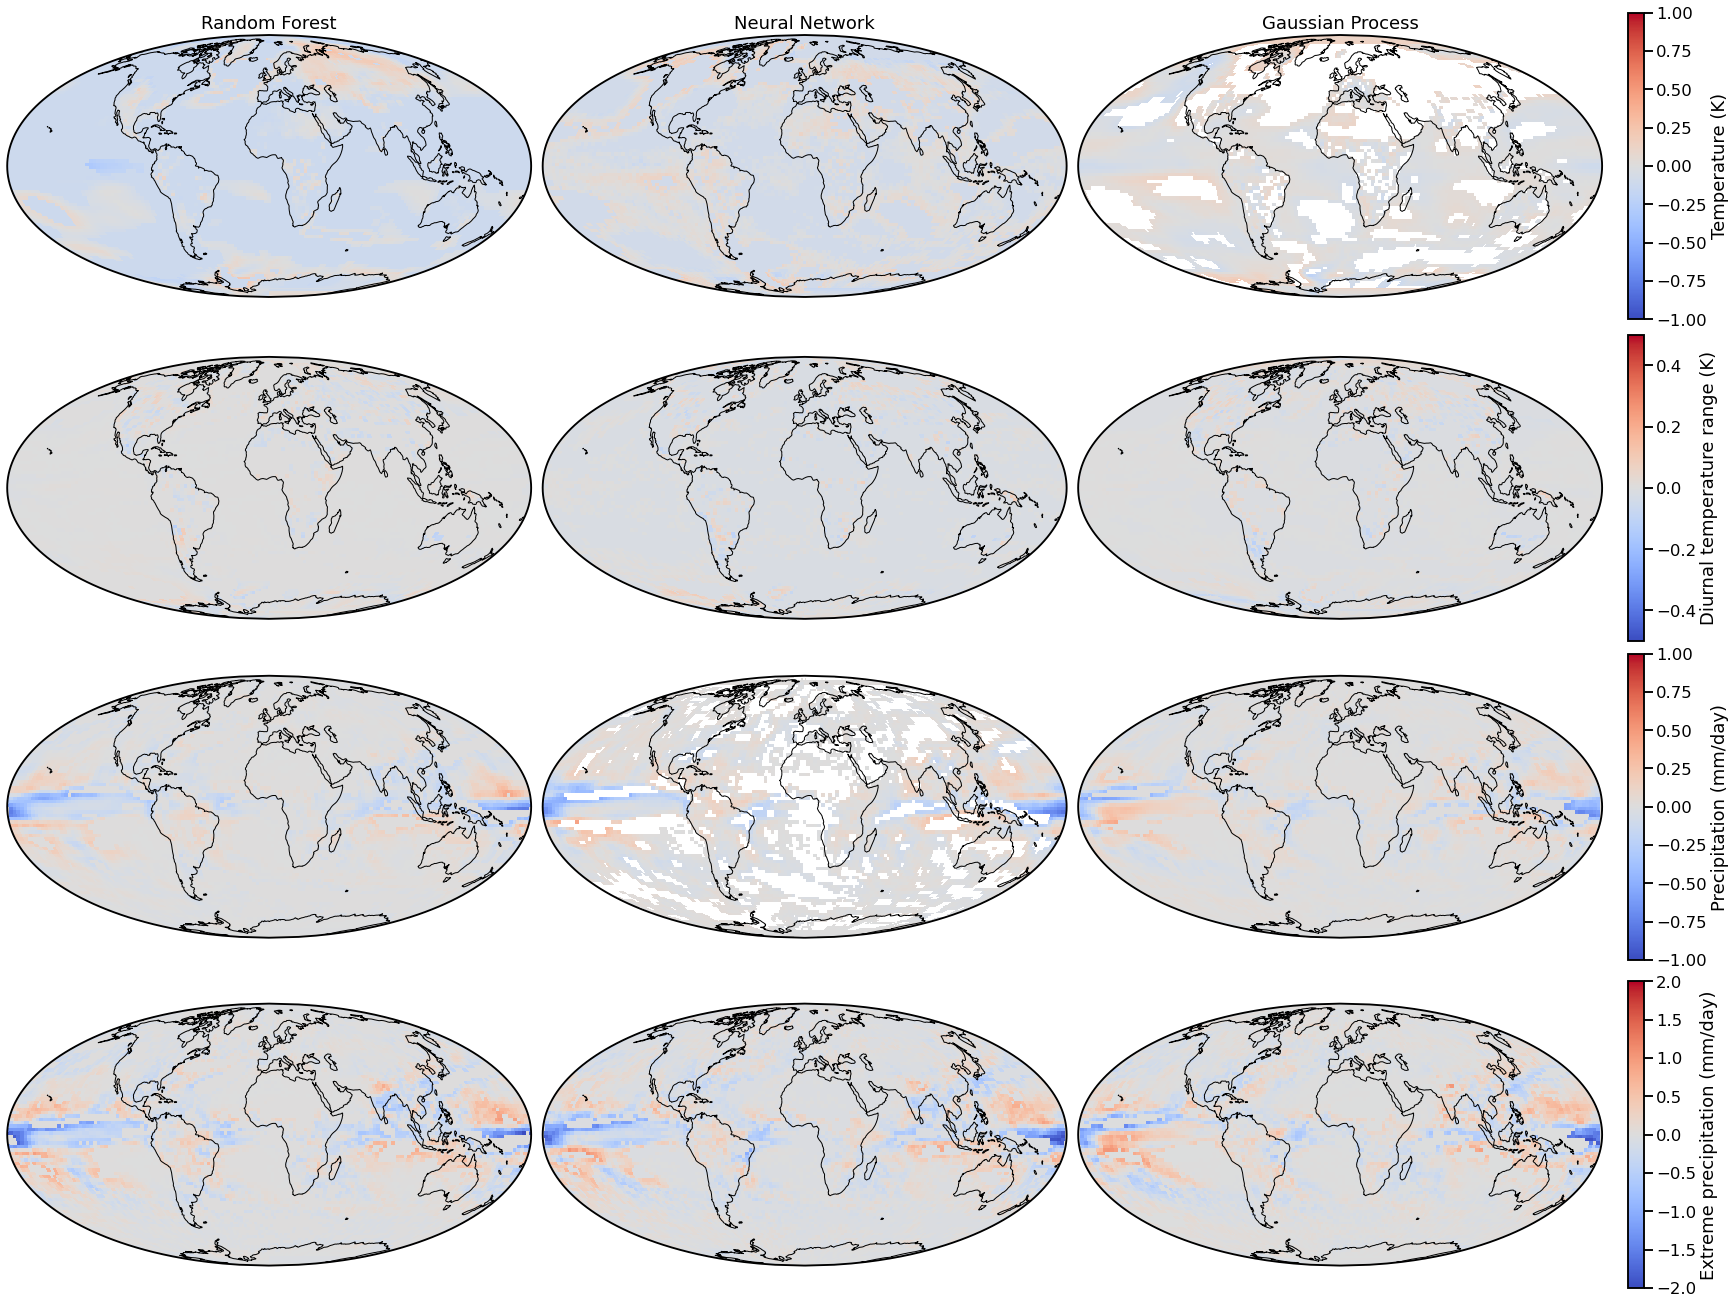

In [13]:
def ttest_rel_from_stats(diff_mean, diff_std, diff_num):
    """
    Calculates the T-test for the means of *two independent* samples of scores.

    This is a two-sided test for the null hypothesis that 2 independent samples
    have identical average (expected) values. This test assumes that the
    populations have identical variances by default.

    It is deliberately similar in interface to the other scipy.stats.ttest_... routines

    See e.g. https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind_from_stats.html
    and pg. 140 in Statistical methods in Atmos Sciences
    
    :param diff: The mean difference, x_d (|x1 - x1| == |x1| - |x2|)
    :param diff_std: The standard deviation in the difference, s_d (sqrt(Var[x_d]))
    :param diff_num: The number of points, n (n == n1 == n2)
    :return float, float: t-statistic, p-value
    """
    from scipy.stats import distributions

    z = diff_mean / np.sqrt(diff_std ** 2 / diff_num)
    # use np.abs to get upper tail, then multiply by two as this is a two-tailed test
    p = distributions.t.sf(np.abs(z), diff_num - 1) * 2
    return z, p

p_level = 0.05

# proj = ccrs.PlateCarree()
kwargs = [dict(vmin=-1, vmax=1), dict(vmin=-0.5, vmax=0.5), dict(vmin=-1, vmax=1), dict(vmin=-2, vmax=2)]


with sns.plotting_context("talk"):

#     fig = plt.figure()
    fig, axes = plt.subplots(4, 3, subplot_kw=dict(projection=proj), figsize=(24, 18), constrained_layout=True)
    print(axes)
    for model_axes, var, label, kws in zip(axes, variables, labels, kwargs):
        for ax, model, model_label in zip(model_axes, models[:-1], model_labels[:-1]):
            if label == 'Temperature (K)':
                ax.set_title(model_label)
            diff = (model[var]-models[-1][var].mean('member')).sel(time=slice(2050, 2100)) # /models[-1][var]
            mean_diff = diff.mean('time')
            _, p = ttest_rel_from_stats(mean_diff, diff.std('time'), diff.count('time'))
            if model_label == 'Gaussian Process':
                mean_diff.where(p > p_level).plot(cmap="coolwarm", ax=ax, add_labels=False, transform=ccrs.PlateCarree(), cbar_kwargs={"label":label, "orientation":'vertical'}, **kws)
            else:
                mean_diff.where(p > p_level).plot(cmap="coolwarm", ax=ax, add_labels=False, transform=ccrs.PlateCarree(), add_colorbar=False, **kws)
            
            ax.coastlines()
                

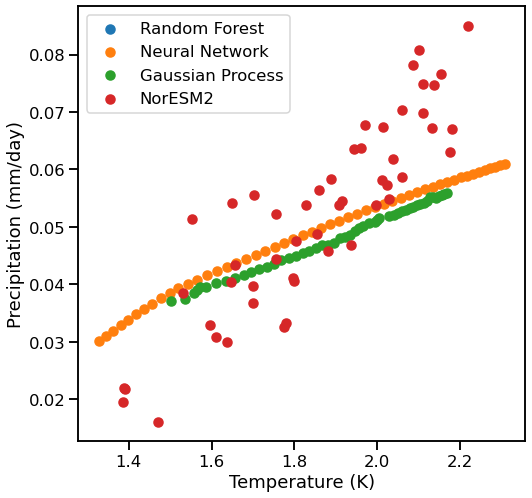

In [52]:
models = [rf_predictions, nn_predictions, gp_predictions, Y.mean('member')]
model_labels = ['Random Forest', "Neural Network", 'Gaussian Process', 'NorESM2']

def global_mean(ds):
    if 'lat' not in ds.coords:
        ds_ = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
    else:
        ds_ = ds
    weights = np.cos(np.deg2rad(ds_.lat))
    return ds_.weighted(weights).mean(['lat', 'lon'])

with sns.plotting_context("talk"):

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    for model, model_label in zip(models, model_labels):
        ax.scatter(global_mean(model['tas'].sel(time=slice(2050, 2100))), global_mean(model['pr'].sel(time=slice(2050, 2100))), label=model_label)
    plt.setp(plt.gca(), xlabel="Temperature (K)", ylabel="Precipitation (mm/day)")
    plt.legend()
                

ValueError: Moving window (=5) must between 1 and 2, inclusive

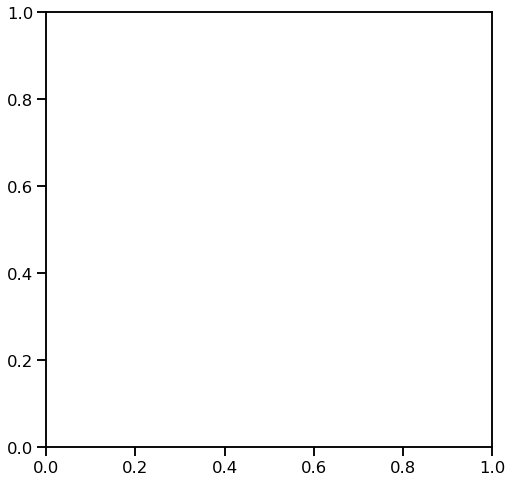

In [53]:
with sns.plotting_context("talk"):

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    for model, model_label in zip(models, model_labels):
        ax.scatter(global_mean(model['tas'].sel(time=slice(2050, 2100))).rolling(time=5, center=True).mean(), global_mean(model['pr'].sel(time=slice(2050, 2100))).rolling(time=5, center=True).mean(), label=model_label)
    plt.setp(plt.gca(), xlabel="Temperature (K)", ylabel="Precipitation (mm/day)")
    plt.legend()

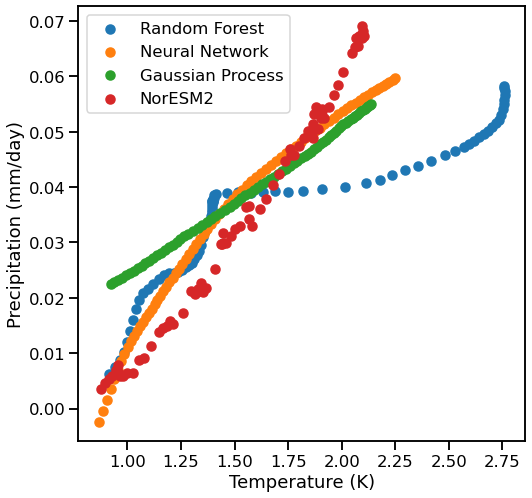

In [54]:
with sns.plotting_context("talk"):

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    for model, model_label in zip(models, model_labels):
        ax.scatter(global_mean(model['tas']).rolling(time=10, center=True).mean(), global_mean(model['pr']).rolling(time=10, center=True).mean(), label=model_label)
    plt.setp(plt.gca(), xlabel="Temperature (K)", ylabel="Precipitation (mm/day)")
    plt.legend()

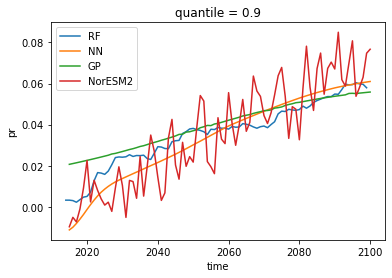

In [61]:
rf_ = rf_predictions.assign_coords(time=rf_predictions.time+ 2014)

global_mean(rf_['pr']).plot(label='RF')
global_mean(nn_predictions['pr']).plot(label='NN')
global_mean(gp_predictions['pr']).plot(label='GP')
global_mean(Y['pr'].mean('member')).plot(label='NorESM2')
plt.legend()

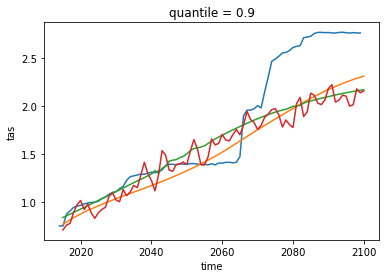

In [62]:
global_mean(rf_['tas']).plot()
global_mean(nn_predictions['tas']).plot()
global_mean(gp_predictions['tas']).plot()
global_mean(Y['tas'].mean('member')).plot()

Energetic slope: [2.] intercept: -0.9999999999999996
Random Forest slope: [0.93880441] intercept: -0.40724667742499987
Neural Network slope: [1.77292068] intercept: -1.2576221470983624
Gaussian Process slope: [1.15034468] intercept: -0.1229695407920397
NorESM2 slope: [2.3446571] intercept: -2.093588592816992


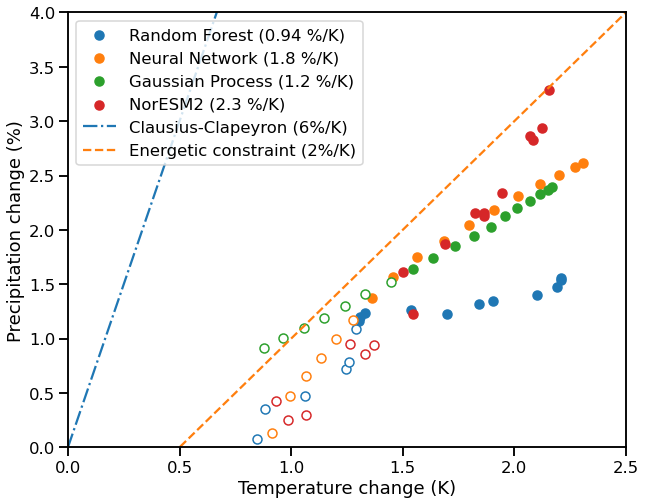

In [85]:
from sklearn.linear_model import LinearRegression

baseline_precip = 2.33511687 # From piControl

with sns.plotting_context("talk"):
    
    x = np.linspace(0, 2.5, 100)
    
    m=LinearRegression().fit(x[:, np.newaxis], x*2-1)
    print("{} slope: {} intercept: {}".format('Energetic', m.coef_, m.intercept_))

    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    for model, model_label in zip(models, model_labels):
        smooth = global_mean(model).rolling(time=10).mean().dropna('time')
        smooth = global_mean(model).coarsen(time=5, boundary='pad').mean().dropna('time')
        x_, y_ = smooth['tas'], smooth['pr']/baseline_precip*100
        m=LinearRegression().fit(x_.data[:, np.newaxis], y_)

        s=ax.scatter(x_.sel(time=slice(2050, None)), y_.sel(time=slice(2050, None)), label="{} ({:0.2} %/K)".format(model_label, m.coef_[0]))
        ax.scatter(x_.sel(time=slice(None, 2050)), y_.sel(time=slice(None, 2050)), facecolor='w', edgecolor=s.get_facecolor())
        print("{} slope: {} intercept: {}".format(model_label, m.coef_, m.intercept_))
    
    plt.plot(x, x*6, label="Clausius-Clapeyron (6%/K)", ls='-.')
    plt.plot(x, x*2-1, label="Energetic constraint (2%/K)", ls='--')
    
    plt.setp(plt.gca(), xlabel="Temperature change (K)", ylabel="Precipitation change (%)", xlim=[0, 2.5], ylim=[0, 4])
    plt.legend(loc='upper left')